## **Installation et récupération des données**

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from helpers2 import S3Connection

In [3]:
s3 = S3Connection(bucket_name="clichere/diffusion")

Connection successful


In [4]:
path_logements_existants = "DPE/DPE_ADEME/dpe-v2-logements-existants.csv"
DPE_existants = s3.read_csv_from_s3(path_logements_existants)

path_logements_neufs = "DPE/DPE_ADEME/dpe-v2-logements-neufs.csv"
DPE_neufs = s3.read_csv_from_s3(path_logements_neufs)

In [5]:
path_vf_2024 = "valeursfoncieres/vf_2024.csv"
vf_2024 = s3.read_csv_from_s3(path_vf_2024)

path_vf_2023 = "valeursfoncieres/vf_2023.csv"
vf_2023 = s3.read_csv_from_s3(path_vf_2023)

path_vf_2022 = "valeursfoncieres/vf_2022.csv"
vf_2022 = s3.read_csv_from_s3(path_vf_2022)

path_vf_2021 = "valeursfoncieres/vf_2021.csv"
vf_2021 = s3.read_csv_from_s3(path_vf_2021)

path_vf_2020 = "valeursfoncieres/vf_2020.csv"
vf_2020 = s3.read_csv_from_s3(path_vf_2020)

path_vf_2019 = "valeursfoncieres/vf_2019.csv"
vf_2019 = s3.read_csv_from_s3(path_vf_2019)

In [ ]:
vf = pd.concat([vf_2022, vf_2021, vf_2020, vf_2023, vf_2024], ignore_index=True)

## **Fonctions utiles**

In [6]:
def analyser_valeurs_aberrantes(df):
    colonnes_numeriques = df.select_dtypes(include=np.number).columns

    for col in colonnes_numeriques:
        serie = df[col].dropna()

        if serie.empty:
            print(f"\nColonne '{col}' vide ou uniquement composée de NaN.")
            continue

        moyenne = serie.mean()
        mediane = serie.median()
        ecart_type = serie.std()

        q1 = serie.quantile(0.25)
        q3 = serie.quantile(0.75)
        iqr = q3 - q1
        borne_inf = q1 - 1.5 * iqr
        borne_sup = q3 + 1.5 * iqr
        nb_aberrantes = ((serie < borne_inf) | (serie > borne_sup)).sum()

        print(f"\nColonne : {col}")
        print(f"  Moyenne     : {moyenne:.2f}")
        print(f"  Médiane     : {mediane:.2f}")
        print(f"  Écart-type  : {ecart_type:.2f}")
        print(f"  Valeurs aberrantes : {nb_aberrantes} (sur {len(serie)})")

        # Affichage du boxplot
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=serie, orient="h", color="skyblue")
        plt.title(f"Boxplot de '{col}'")
        plt.tight_layout()
        plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyse(df):
    # --- Paramètres généraux ---
    couleurs_dpe = {
        "A": "#006400", "B": "#228B22", "C": "#7CFC00",
        "D": "#FFD700", "E": "#FFA500", "F": "#FF8C00", "G": "#FF0000",
    }

    def statistiques_generales(df):
        print("====== STATISTIQUES GÉNÉRALES ======")
        print(f"Nombre de lignes : {len(df)}")
        total_nan = df.isna().sum().sum()
        print(f"Nombre total de valeurs manquantes (NaN) : {total_nan}")
        top_nan = df.isna().sum().sort_values(ascending=False).head(10)
        print("Top 10 colonnes avec le plus de NaN :\n", top_nan)

    def analyse_colonnes(df):
        print("\n====== ANALYSE PAR COLONNE ======")
        for col in df.columns:
            print(f"\n--- Colonne : {col} ---")
            print(f"Type : {df[col].dtype}")
            print(f"Valeurs uniques : {df[col].nunique()}")
            print(f"Valeurs manquantes : {df[col].isna().sum()}")

            if pd.api.types.is_numeric_dtype(df[col]):
                print("Statistiques descriptives :\n", df[col].describe())
                # Détection des valeurs aberrantes (outliers)
                q1, q3 = df[col].quantile([0.25, 0.75])
                iqr = q3 - q1
                lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
                outliers = df[(df[col] < lower) | (df[col] > upper)]
                print(f"Valeurs aberrantes (méthode IQR) : {len(outliers)}")
            elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
                print("Top modalités :\n", df[col].value_counts(dropna=False).head(10))

    def histogramme_dpe(df):
        print("\n====== HISTOGRAMME DPE GÉNÉRAL ======")
        dpe_counts = df["Etiquette_DPE"].value_counts(normalize=True).reindex(["A", "B", "C", "D", "E", "F", "G"]) * 100
        colors = [couleurs_dpe.get(dpe, "grey") for dpe in dpe_counts.index]

        fig, ax = plt.subplots(figsize=(8, 5))
        bars = ax.bar(dpe_counts.index, dpe_counts.values, color=colors)
        ax.set_title("Répartition des étiquettes DPE")
        ax.set_xlabel("Étiquette DPE")
        ax.set_ylabel("Pourcentage")
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}%", ha='center')
        plt.tight_layout()
        plt.show()

    def analyse_par_departement(df):
        print("\n====== ANALYSE PAR DÉPARTEMENT ======")
        df_dep = df.copy()
        df_dep["N°_département_(BAN)"] = pd.to_numeric(df_dep["N°_département_(BAN)"], errors="coerce")
        df_dep = df_dep[df_dep["N°_département_(BAN)"] <= 101]
        df_dep["N°_département_(BAN)"] = df_dep["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)

        repartition = df_dep.groupby("N°_département_(BAN)")["Etiquette_DPE"].value_counts(normalize=True).unstack() * 100
        print("Pourcentage d'étiquettes DPE par département :\n", repartition)

        for dep in ["75", "92", "13", "44"]:
            if dep in repartition.index:
                dpe_values = repartition.loc[dep].reindex(["A", "B", "C", "D", "E", "F", "G"])
                colors = [couleurs_dpe.get(k, "grey") for k in dpe_values.index]
                plt.figure()
                bars = plt.bar(dpe_values.index, dpe_values.values, color=colors)
                plt.title(f"DPE - Département {dep}")
                plt.ylabel("Pourcentage")
                plt.xlabel("Étiquette DPE")
                for bar in bars:
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}%", ha='center')
                plt.tight_layout()
                plt.show()

        dep_A = df_dep[df_dep["Etiquette_DPE"] == "A"]["N°_département_(BAN)"].value_counts().idxmax()
        dep_G = df_dep[df_dep["Etiquette_DPE"] == "G"]["N°_département_(BAN)"].value_counts().idxmax()
        print(f"Département avec le plus de logements en A : {dep_A}")
        print(f"Département avec le plus de logements en G : {dep_G}")

    def analyse_par_type_batiment(df):
        print("\n====== ANALYSE PAR TYPE DE BÂTIMENT ======")
        types = df["Type_bâtiment"].value_counts()
        print("Types de bâtiments présents :\n", types)

        plt.figure(figsize=(5, 5))
        plt.pie(types, labels=types.index, autopct='%1.1f%%', startangle=90,
                colors=["#6495ED", "#87CEFA", "#1E90FF"])
        plt.title("Répartition par type de bâtiment")
        plt.axis('equal')
        plt.show()

        tableau = df.groupby(["Type_bâtiment", "Etiquette_DPE"]).size().unstack(fill_value=0)
        pourcentages = (tableau.T / tableau.sum(axis=1)).T * 100
        print("Pourcentage d’étiquettes DPE par type de bâtiment :\n", pourcentages)

        type_max_A = df[df["Etiquette_DPE"] == "A"]["Type_bâtiment"].value_counts().idxmax()
        type_max_E = df[df["Etiquette_DPE"] == "E"]["Type_bâtiment"].value_counts().idxmax()
        print(f"Type de bâtiment avec le plus de logements en A : {type_max_A}")
        print(f"Type de bâtiment avec le plus de logements en E : {type_max_E}")

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        for i, t in enumerate(['appartement', 'immeuble', 'maison']):
            if t in pourcentages.index:
                dpe_vals = pourcentages.loc[t].reindex(["A", "B", "C", "D", "E", "F", "G"])
                colors = [couleurs_dpe.get(dpe, "grey") for dpe in dpe_vals.index]
                bars = axes[i].bar(dpe_vals.index, dpe_vals.values, color=colors)
                axes[i].set_title(f"{t.capitalize()} - Répartition DPE")
                axes[i].set_ylabel("Pourcentage")
                axes[i].set_xlabel("Étiquette DPE")
                for bar in bars:
                    axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.1f}%", ha='center')
        plt.tight_layout()
        plt.show()

    # --- Appels des fonctions ---
    statistiques_generales(df)
    analyse_colonnes(df)
    histogramme_dpe(df)
    analyse_par_departement(df)
    analyse_par_type_batiment(df)


## **Analyse**

====== Statistiques Générales ======
Nombre de lignes : 4537525
Nombre total de NaN : 17334637
Top 10 colonnes avec le plus de NaN :
 Cage_d'escalier                  4473586
Nom_résidence                    4187600
Complément_d'adresse_bâtiment    2567157
Complément_d'adresse_logement    2195128
Année_construction               1484043
N°_étage_appartement             1145452
N°_voie_(BAN)                     630304
Nom__rue_(BAN)                    347796
Surface_habitable_logement         52267
Adresse_(BAN)                      29373
dtype: int64

====== Analyse de chaque colonne ======

--- Date_réception_DPE ---
Type : object
Valeurs uniques : 697
Valeurs manquantes : 0
Top modalités :
 Date_réception_DPE
2023-02-23    16943
2023-05-03    16649
2023-05-25    16603
2023-02-27    16593
2023-05-22    16004
2023-04-24    15988
2023-03-30    15550
2023-03-23    15492
2023-04-26    15337
2023-02-28    15320
Name: count, dtype: int64

--- Date_établissement_DPE ---
Type : object
Valeurs

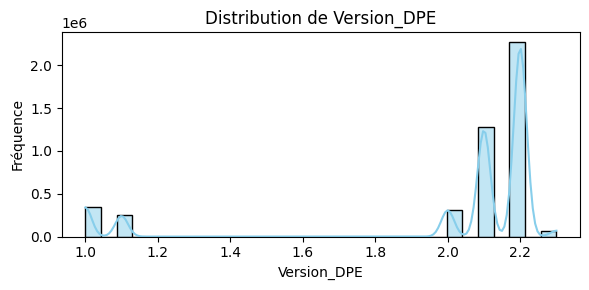


--- Méthode_application_DPE ---
Type : object
Valeurs uniques : 6
Valeurs manquantes : 0
Top modalités :
 Méthode_application_DPE
dpe appartement individuel                                                    2198900
dpe maison individuelle                                                       1563858
dpe appartement généré à partir des données DPE immeuble                       714840
dpe immeuble collectif                                                          48811
dpe issu d'une étude thermique réglementaire RT2012 bâtiment : appartement      10810
dpe issu d'une étude thermique réglementaire RT2012 bâtiment : immeuble           306
Name: count, dtype: int64

--- Etiquette_DPE ---
Type : object
Valeurs uniques : 7
Valeurs manquantes : 0
Top modalités :
 Etiquette_DPE
D    1482495
C    1090457
E    1027779
F     465613
G     328297
B     114556
A      28328
Name: count, dtype: int64

--- Etiquette_GES ---
Type : object
Valeurs uniques : 7
Valeurs manquantes : 0
Top modalités :
 Et

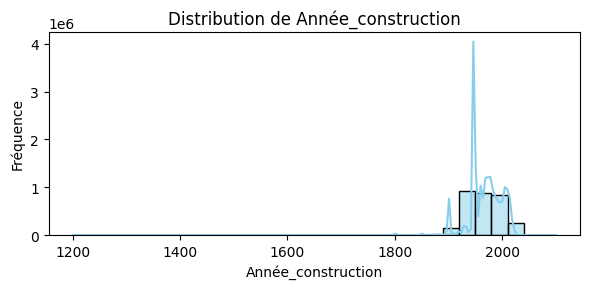


--- Type_bâtiment ---
Type : object
Valeurs uniques : 3
Valeurs manquantes : 0
Top modalités :
 Type_bâtiment
appartement    2924550
maison         1563858
immeuble         49117
Name: count, dtype: int64

--- Période_construction ---
Type : object
Valeurs uniques : 10
Valeurs manquantes : 0
Top modalités :
 Période_construction
1948-1974     1446049
avant 1948    1324650
1989-2000      414614
2006-2012      338338
1978-1982      245130
1983-1988      211537
2013-2021      188886
1975-1977      188342
2001-2005      146898
après 2021      33081
Name: count, dtype: int64

--- Surface_habitable_logement ---
Type : float64
Valeurs uniques : 6349
Valeurs manquantes : 52267
Statistiques descriptives :
 count    4.485258e+06
mean     7.639371e+01
std      2.857304e+03
min      2.800000e+00
25%      4.660000e+01
50%      6.700000e+01
75%      9.000000e+01
max      6.029033e+06
Name: Surface_habitable_logement, dtype: float64
Valeurs aberrantes (IQR) : 218707


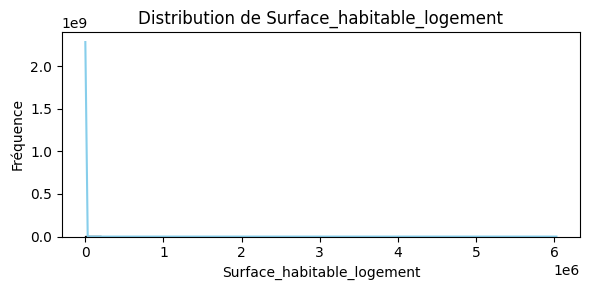


--- Adresse_brute ---
Type : object
Valeurs uniques : 2401203
Valeurs manquantes : 303
Top modalités :
 Adresse_brute
.                         16095
de la République           3029
Grande Rue                 2616
Victor Hugo                2504
Pasteur                    2203
du Général de Gaulle       2015
Jean Jaurès                1983
Gambetta                   1886
16 AVENUE EMILE BAUDOT     1867
Le Bourg                   1661
Name: count, dtype: int64

--- Nom__commune_(BAN) ---
Type : object
Valeurs uniques : 35481
Valeurs manquantes : 22778
Top modalités :
 Nom__commune_(BAN)
Paris          203691
Lyon            65562
Marseille       63585
Toulouse        56646
Nantes          39979
Bordeaux        34161
Reims           29393
Nice            29296
Montpellier     28400
Lille           27712
Name: count, dtype: int64

--- Code_INSEE_(BAN) ---
Type : object
Valeurs uniques : 34492
Valeurs manquantes : 22778
Top modalités :
 Code_INSEE_(BAN)
31555    56675
44109    39994
33063

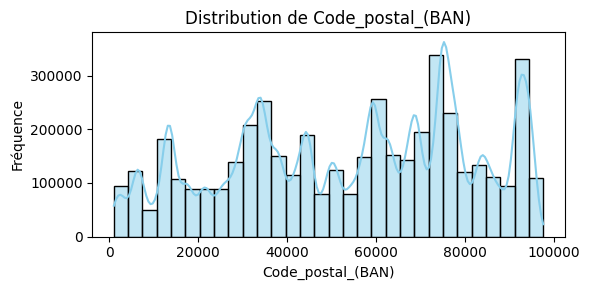


--- Score_BAN ---
Type : float64
Valeurs uniques : 94
Valeurs manquantes : 22778
Statistiques descriptives :
 count    4.514747e+06
mean     6.516803e-01
std      1.697716e-01
min      0.000000e+00
25%      5.300000e-01
50%      6.400000e-01
75%      7.600000e-01
max      1.000000e+00
Name: Score_BAN, dtype: float64
Valeurs aberrantes (IQR) : 8614


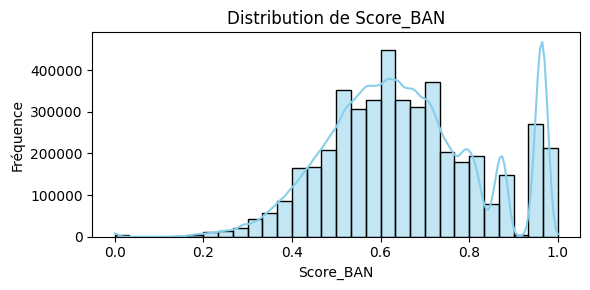


--- Nom__rue_(BAN) ---
Type : object
Valeurs uniques : 426717
Valeurs manquantes : 347796
Top modalités :
 Nom__rue_(BAN)
NaN                            347796
Grande Rue                      16223
.                               13601
Rue de la République            11127
Rue Victor Hugo                 11103
Rue Pasteur                     10173
Rue de Paris                     7939
Rue Jean Jaurès                  7250
Avenue du Général de Gaulle      7159
Avenue Jean Jaurès               7060
Name: count, dtype: int64

--- Coordonnée_cartographique_X_(BAN) ---
Type : float64
Valeurs uniques : 2066771
Valeurs manquantes : 22778
Statistiques descriptives :
 count    4.514747e+06
mean     6.703253e+05
std      2.050150e+05
min      0.000000e+00
25%      5.516852e+05
50%      6.567914e+05
75%      8.394724e+05
max      1.241817e+06
Name: Coordonnée_cartographique_X_(BAN), dtype: float64
Valeurs aberrantes (IQR) : 6744


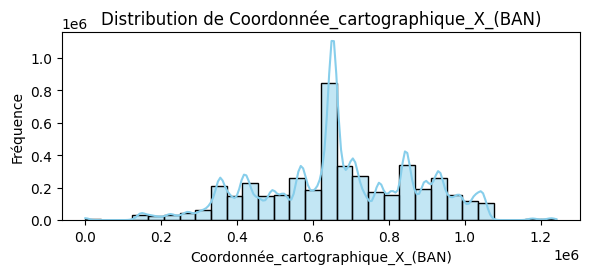


--- Coordonnée_cartographique_Y_(BAN) ---
Type : float64
Valeurs uniques : 2064566
Valeurs manquantes : 22778
Statistiques descriptives :
 count    4.514747e+06
mean     6.646746e+06
std      4.000151e+05
min      0.000000e+00
25%      6.456605e+06
50%      6.715898e+06
75%      6.863089e+06
max      8.587745e+06
Name: Coordonnée_cartographique_Y_(BAN), dtype: float64
Valeurs aberrantes (IQR) : 12681


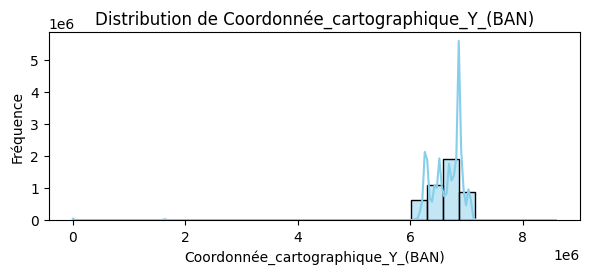


--- Code_postal_(brut) ---
Type : int64
Valeurs uniques : 7399
Valeurs manquantes : 0
Statistiques descriptives :
 count    4.537525e+06
mean     5.369903e+04
std      2.671280e+04
min      0.000000e+00
25%      3.300000e+04
50%      5.750000e+04
75%      7.502000e+04
max      9.900000e+04
Name: Code_postal_(brut), dtype: float64
Valeurs aberrantes (IQR) : 0


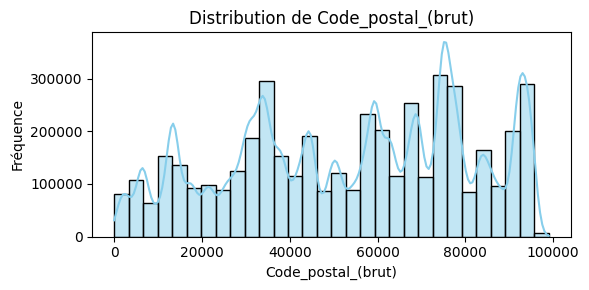


--- N°_étage_appartement ---
Type : float64
Valeurs uniques : 38
Valeurs manquantes : 1145452
Statistiques descriptives :
 count    3.392073e+06
mean     1.824890e-01
std      1.375986e+00
min     -6.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.951000e+03
Name: N°_étage_appartement, dtype: float64
Valeurs aberrantes (IQR) : 250646


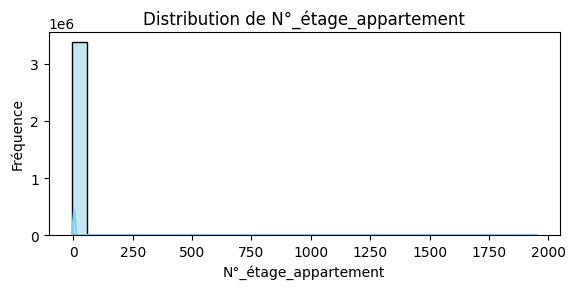


--- Nom_résidence ---
Type : object
Valeurs uniques : 110874
Valeurs manquantes : 4187600
Top modalités :
 Nom_résidence
NaN                               4187600
Bâtiment                            86173
Immeuble                            13782
Appartement                          8205
Maison individuelle                  2411
Bâtiment A                           2122
Bâtiment B                           2084
immeuble                             1969
Lot :  / Étage : RDC / Porte :       1610
BP 50209 Bâtiment                    1246
Name: count, dtype: int64

--- Cage_d'escalier ---
Type : object
Valeurs uniques : 1371
Valeurs manquantes : 4473586
Top modalités :
 Cage_d'escalier
NaN           4473586
Sans objet      21247
1                6684
01               3536
-                3198
A                2867
B                2547
2                1737
C                1244
02               1224
Name: count, dtype: int64

--- Complément_d'adresse_logement ---
Type : object
Valeurs u

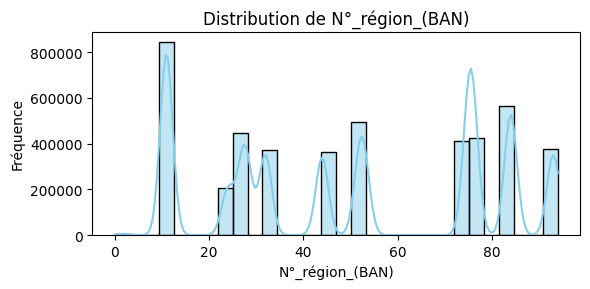


--- Complément_d'adresse_bâtiment ---
Type : object
Valeurs uniques : 1182630
Valeurs manquantes : 2567157
Top modalités :
 Complément_d'adresse_bâtiment
NaN           2567157
dpe             41477
Sans objet      20753
A                6160
B                4962
1                3385
0001             2761
C                2537
-                2343
47582-1          1867
Name: count, dtype: int64


NameError: name 'matching3' is not defined

In [8]:
analyse(DPE_existants)